<h2>Initializing</h2>
<h5>Importing dependencies and visualizing data</h5>

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from category_encoders import CountEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, Normalizer, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

np.random.seed(42)

In [2]:
data = pd.read_csv('income.csv')

data.head()

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income >50K
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


<h2> Data analysis </h2>
<h5> Check missing data</h5>

In [3]:
pd.Series(data.isnull().sum() / data.index.size * 100, name='Missing values percentage')

age               0.000000
workclass         5.638647
education         0.000000
education-num     0.000000
marital-status    0.000000
occupation        5.660146
relationship      0.000000
race              0.000000
sex               0.000000
capital-gain      0.000000
capital-loss      0.000000
hours-per-week    0.000000
native-country    1.790486
income >50K       0.000000
Name: Missing values percentage, dtype: float64

<h5> Split data and get its numerical and categorical columns </h5>

In [4]:
features = data.drop(['income >50K'], axis=1)
target = data['income >50K']

X_train, X_valid, y_train, y_valid = train_test_split(features, target, test_size=0.25)

num_cols = [col for col in features.columns if pd.api.types.is_numeric_dtype(features[col])]
cat_cols = [col for col in features.columns if pd.api.types.is_string_dtype(features[col])]

<h5> Check how many different categorical values are in each column (useful to decide which encoding to use) </h5>

In [5]:
uniques = pd.Series(features[cat_cols].apply(lambda col: col.value_counts().size), name='Unique values count per column').sort_values()

OH_cols = [feature for feature in uniques.index if uniques[feature] < 10]
CE_cols = list(set(uniques.index) - set(OH_cols))

uniques

sex                2
race               5
relationship       6
marital-status     7
workclass          8
occupation        14
education         16
native-country    41
Name: Unique values count per column, dtype: int64

<h5> Check if there are unique values in the test set that are not present in the train set </h5>

In [6]:
def check_consistency(df_train, df_test, categorical_cols):
    uniques_train = {key:set(df_train[key]) for key in categorical_cols}
    uniques_test = {key:set(df_test[key]) for key in categorical_cols}
    uniques_comparison = [bool(uniques_test[key] - uniques_train[key]) for key in categorical_cols]
    return pd.Series(categorical_cols)[uniques_comparison].to_list()
print('Inconsistent columns: ', check_consistency(X_train, X_valid, cat_cols))

Inconsistent columns:  []


<h5> Check training data distributions to decide which scaler/normalizer to use </h5>

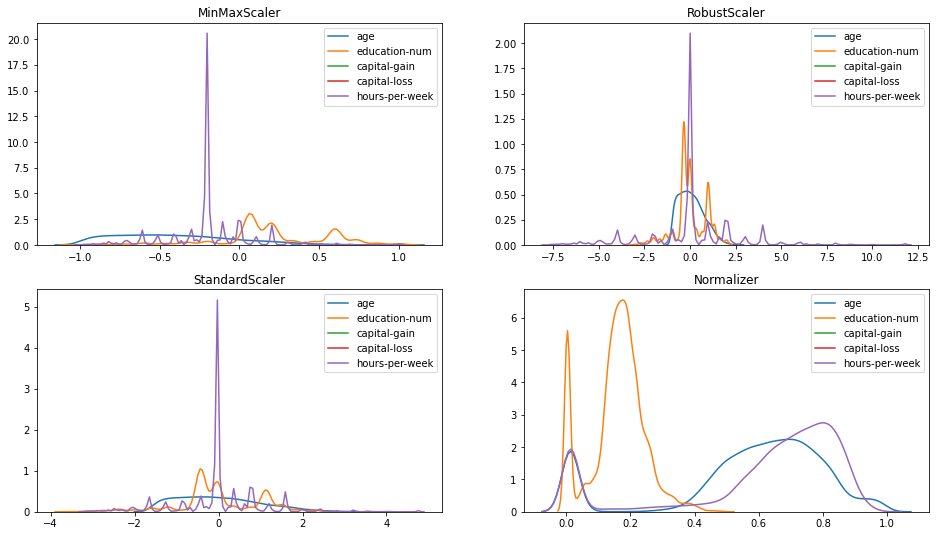

In [7]:
transformers = iter([MinMaxScaler(feature_range=(-1,1)), RobustScaler(), StandardScaler(), Normalizer()])
fig, axes = plt.subplots(2,2, figsize=(16,9))
for subp in [(0,0),(0,1),(1,0),(1,1)]:
    transformer = next(transformers)
    transformed = pd.DataFrame(transformer.fit_transform(X_train[num_cols]), columns=num_cols)
    for col in num_cols:
        sns.kdeplot(data=transformed[col], ax=axes[subp])
        axes[subp].set_title(repr(transformer).split("(")[0])

<h2> Preprocessing data </h2>
<h5> Now we can properly start preprocessing data</h5>

In [8]:
num_transformer = make_pipeline(SimpleImputer(strategy='median'),
                                StandardScaler())
OH_transformer = make_pipeline(SimpleImputer(strategy='most_frequent'),
                               OneHotEncoder(sparse=False))
CE_transformer = make_pipeline(SimpleImputer(strategy='most_frequent'),
                               CountEncoder(min_group_size=1),
                               StandardScaler())
preprocessor = make_column_transformer((num_transformer, num_cols),
                                       (OH_transformer, OH_cols),
                                       (CE_transformer, CE_cols))
X_train = pd.DataFrame(preprocessor.fit_transform(X_train, y_train), index=X_train.index).dropna()
X_valid = pd.DataFrame(preprocessor.transform(X_valid), index=X_valid.index)

<h2> Modelling </h2>
<h5> Using a simple network with sigmoid activation </h5>

In [13]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([layers.Dense(512, activation='relu', input_dim=X_train.shape[1]),
                          layers.BatchNormalization(),
                          layers.Dropout(0.3),
                          layers.Dense(512, activation='relu'),
                          layers.BatchNormalization(),
                          layers.Dropout(0.3),
                          layers.Dense(1, activation='sigmoid')])
model.compile(optimizer = keras.optimizers.Nadam(lr=0.01),
              loss = 'binary_crossentropy',
              metrics = ['binary_accuracy'])

<h3> Training </h3>

In [14]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.01,
    restore_best_weights=True
)
train_history = model.fit(X_train, y_train,
                          validation_data = (X_valid, y_valid),
                          batch_size = 512,
                          epochs = 100,
                          callbacks = [early_stopping],
                          verbose = 0)

<h3> Evaluate the model </h3>
<h5> Now we can see the results of our training </h5>

Text(0.5, 0, 'Epochs')

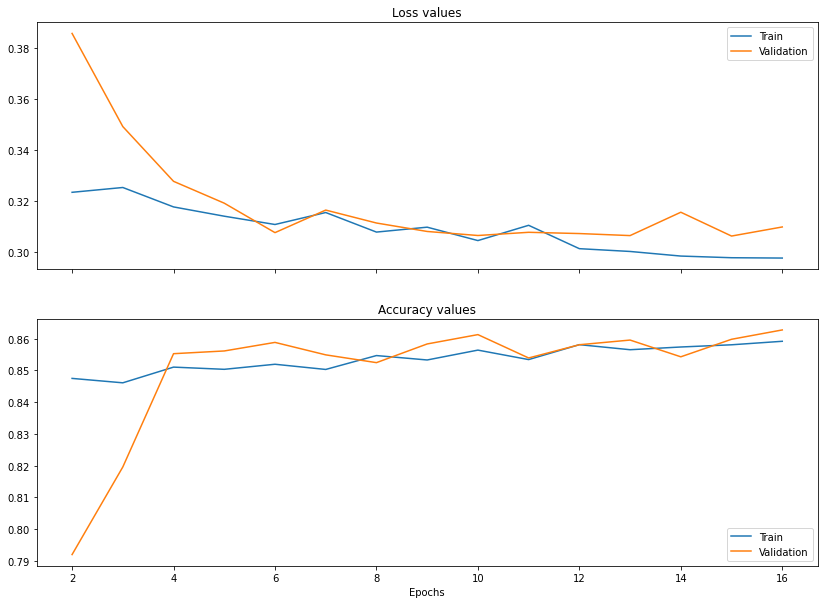

In [15]:
history_df = pd.DataFrame(train_history.history)
fig, axes = plt.subplots(2,1, sharex=True, figsize=(14,10))

axes[0].plot(history_df.loc[2:,['loss', 'val_loss']])
axes[0].legend(['Train', 'Validation'])
axes[0].set_title('Loss values')

axes[1].plot(history_df.loc[2:, ['binary_accuracy', 'val_binary_accuracy']])
axes[1].legend(['Train', 'Validation'], loc='lower right')
axes[1].set_title('Accuracy values')
axes[1].set_xlabel('Epochs')

In [16]:
print(f'Final accuracy: {model.evaluate(X_valid, y_valid, verbose=0)[1]:.2%}')

Final accuracy: 85.89%
